# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os

import shutil
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import imutils
from tqdm.autonotebook import tqdm


# model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 检查GPU是否可用
print(tf.config.list_physical_devices("GPU"))

RANDOM_SEED = 123

C:\Users\zzc\AppData\Local\Temp\ipykernel_23000\448382705.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Data

In [2]:
yes_dir = Path("./dataset/brain_tumor_dataset/yes")
no_dir = Path("./dataset/brain_tumor_dataset/no")
IMG_SIZE = (224, 224)

# 处理图片

图像四周存在大量黑片，需要去除
这里使用opencv的findContours查找轮廓，然后找到最大的轮廓，然后用这个轮廓找到四周最远的点，然后裁剪

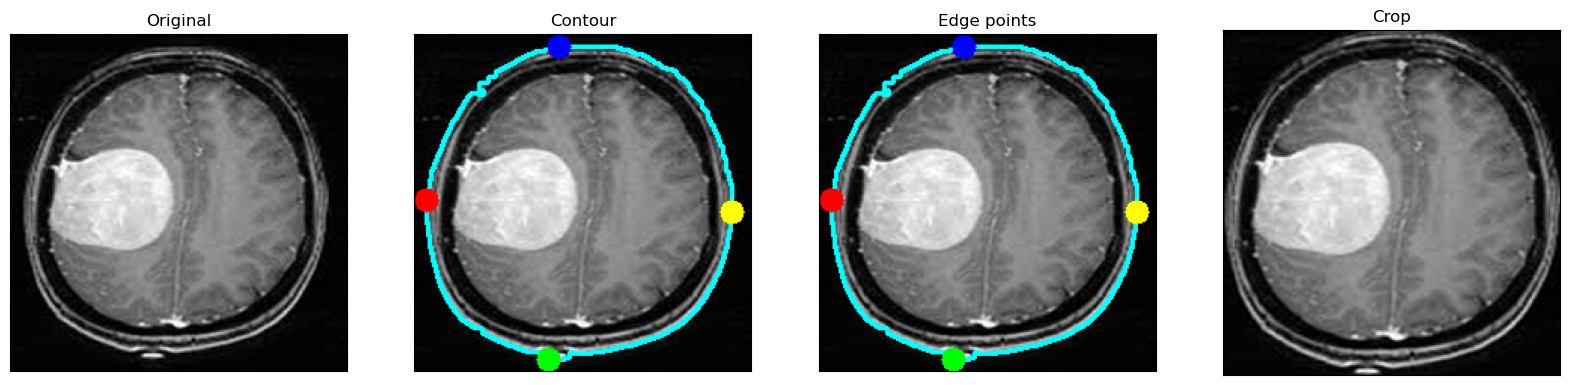

In [26]:
sample_img = cv2.imread(os.path.join(yes_dir, "Y1.jpg"))
# sample_img = cv2.imread(os.path.join(yes_dir, "Y108.jpg"))
# 调整图像大小
sample_img = cv2.resize(sample_img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
# 转换为灰度图像
gary = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
# 高斯模糊
gary = cv2.GaussianBlur(gary, (5, 5), 0)

# 二值化
_, thresh = cv2.threshold(gary, 25, 255, cv2.THRESH_BINARY)
# 腐蚀，膨胀
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours
conts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
c = max(conts, key=cv2.contourArea)

# edge points

edge_top = tuple(c[c[:, :, 1].argmin()][0])
edge_bottom = tuple(c[c[:, :, 1].argmax()][0])
edge_left = tuple(c[c[:, :, 0].argmin()][0])
edge_right = tuple(c[c[:, :, 0].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(sample_img.copy(), [c], -1, (0, 255, 255), 2)

# add edge points on the image

img_pnt = cv2.circle(img_cnt, edge_top, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_cnt, edge_bottom, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_cnt, edge_left, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_cnt, edge_right, 8, (255, 255, 0), -1)

# crop
croped_img = sample_img[
    edge_top[1] : edge_bottom[1], edge_left[0] : edge_right[0]
].copy()


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(sample_img)
axes[0].set_title("Original")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(img_cnt)
axes[1].set_title("Contour")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(img_pnt)
axes[2].set_title("Edge points")
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(croped_img)
axes[3].set_title("Crop")
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.show()

# Preprocessing data

In [3]:
# clean

shutil.rmtree("./dataset/preview/")
shutil.rmtree("./dataset/TRAIN/")
shutil.rmtree("./dataset/TEST/")
shutil.rmtree("./dataset/VAL/")
shutil.rmtree("./dataset/TRAIN_CROPED/")
shutil.rmtree("./dataset/TEST_CROPED/")
shutil.rmtree("./dataset/VAL_CROPED/")

In [27]:
def load_files(dirpath: str) -> list:
    paths = []
    for file in tqdm(os.listdir(dirpath)):
        if file.startswith("."):
            continue
        paths.append(os.path.join(dirpath, file))
    return paths


yes_files = load_files(yes_dir)
no_files = load_files(no_dir)

print(f"yes: total {len(yes_files)}")
print(f"no: total {len(no_files)}")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

yes: total 155
no: total 98


查看样本

In [5]:
def plot_samples(dir_path, n=30):
    for label in ["yes", "no"]:
        d = dir_path / label
        j = 10
        i = int(n / j)
        plt.figure(figsize=(15, 6))
        for idx, file in enumerate(os.listdir(d)[:n]):
            img = cv2.imread(os.path.join(d, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(i, j, idx + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img)
            plt.suptitle(f"{label} samples")
        plt.show()

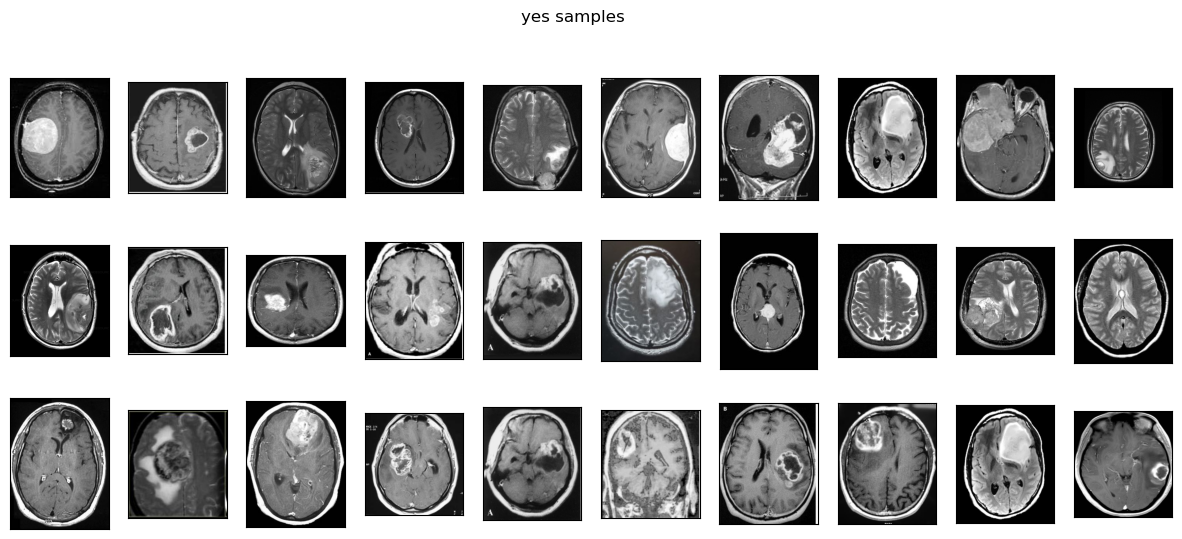

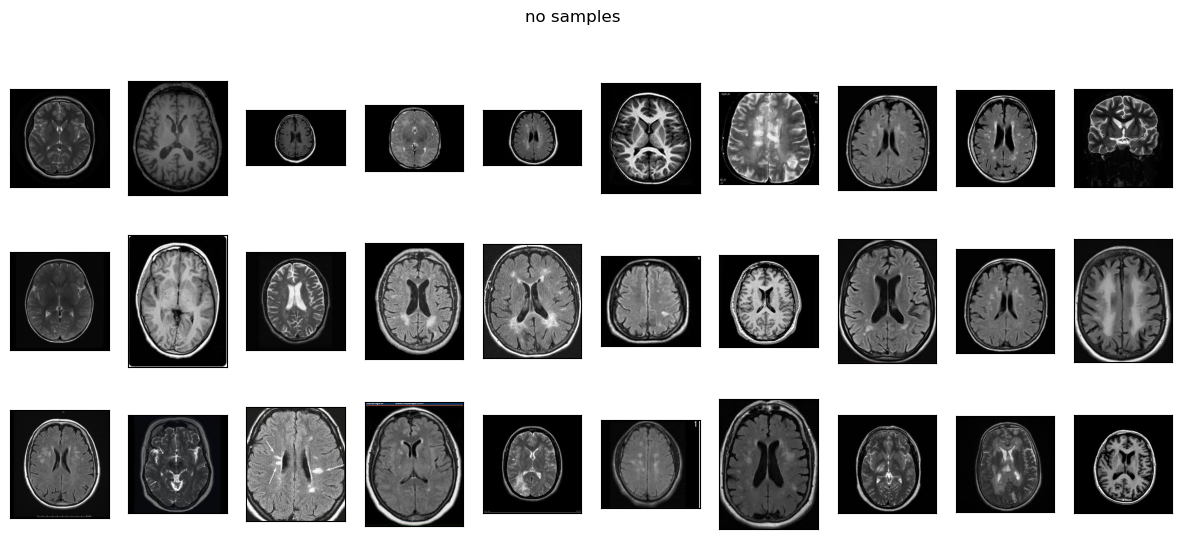

In [7]:
plot_samples(Path("./dataset/"), n=30)

分割数据集，这里因为图片较少，测试集固定为5张，剩下的图片按照8:2分割为训练集和验证集

In [6]:
train_yes_files, val_yes_files = train_test_split(
    yes_files, train_size=0.8, random_state=RANDOM_SEED
)
train_yes_files, test_yes_files = train_test_split(
    train_yes_files, test_size=5, random_state=RANDOM_SEED
)

train_no_files, val_no_files = train_test_split(
    no_files, train_size=0.8, random_state=RANDOM_SEED
)
train_no_files, test_no_files = train_test_split(
    train_no_files, test_size=5, random_state=RANDOM_SEED
)

print(
    f"yes train: {len(train_yes_files)} val: {len(val_yes_files)} test: {len(test_yes_files)}"
)
print(
    f"no train: {len(train_no_files)} val: {len(val_no_files)} test: {len(test_no_files)}"
)

yes train: 119 val: 31 test: 5
no train: 73 val: 20 test: 5


In [7]:
# 用于存储原始图像
TRAIN_DIR = Path("./dataset/TRAIN")
VAL_DIR = Path("./dataset/VAL")
TEST_DIR = Path("./dataset/TEST")
# 用于存储裁剪、处理后的图像
TRAIN_DIR_CROPED = Path("./dataset/TRAIN_CROPED")
VAL_DIR_CROPED = Path("./dataset/VAL_CROPED")
TEST_DIR_CROPED = Path("./dataset/TEST_CROPED")

for path in [
    TRAIN_DIR,
    VAL_DIR,
    TEST_DIR,
    TRAIN_DIR_CROPED,
    VAL_DIR_CROPED,
    TEST_DIR_CROPED,
]:
    for label in ["yes", "no"]:
        d = path / label
        if not d.exists():
            d.mkdir(parents=True)

In [8]:
for file in train_yes_files:
    shutil.copy(file, TRAIN_DIR / "yes")
for file in train_no_files:
    shutil.copy(file, TRAIN_DIR / "no")

for file in val_yes_files:
    shutil.copy(file, VAL_DIR / "yes")
for file in val_no_files:
    shutil.copy(file, VAL_DIR / "no")

for file in test_yes_files:
    shutil.copy(file, TEST_DIR / "yes")
for file in test_no_files:
    shutil.copy(file, TEST_DIR / "no")

In [9]:
def load_data(dir_path, img_size=(224, 224)):
    # 图片转为矩阵
    X = []
    y = []
    for path in tqdm(os.listdir(dir_path)):
        if path.startswith("."):
            continue
        for file in tqdm(os.listdir(os.path.join(dir_path, path))):
            if file.startswith("."):
                continue
            img = cv2.imread(os.path.join(dir_path, path, file))
            # 如果最后需要转成np.array, 需要每张图片的大小一致
            # img = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)
            X.append(img)
            y.append(path)
    # return np.array(X), np.array(y)
    return X, y


X_train, y_train = load_data(TRAIN_DIR, img_size=IMG_SIZE)
X_val, y_val = load_data(VAL_DIR, img_size=IMG_SIZE)
X_test, y_test = load_data(TEST_DIR, img_size=IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
def crop_imgs(imgs, add_pixels_value: int = 0):
    "裁切处理图片"
    croped_imgs = []
    for img in tqdm(imgs):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # threshold
        _, thresh = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY, gray)
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        # find contours
        cnts = cv2.findContours(
            thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        # edge points
        edge_bottom = tuple(c[c[:, :, 1].argmax()][0])
        edge_top = tuple(c[c[:, :, 1].argmin()][0])
        edge_left = tuple(c[c[:, :, 0].argmin()][0])
        edge_right = tuple(c[c[:, :, 0].argmax()][0])

        # crop
        croped = img[
            edge_top[1] - add_pixels_value : edge_bottom[1] + add_pixels_value,
            edge_left[0] - add_pixels_value : edge_right[0] + add_pixels_value,
        ].copy()
        croped_imgs.append(croped)
    return croped_imgs


X_train_croped = crop_imgs(X_train)
X_val_croped = crop_imgs(X_val)
X_test_croped = crop_imgs(X_test)

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
def save_new_imgs(imgs: list, labels: list, dst_dir: str):
    for i, (img, label) in tqdm(
        enumerate(zip(imgs, labels)), desc=f"save new imgs to {dst_dir}"
    ):
        dst = Path(os.path.join(dst_dir, label))
        dst.mkdir(parents=True, exist_ok=True)

        cv2.imwrite(os.path.join(dst, f"{i+1}.jpg"), img)


save_new_imgs(X_train_croped, y_train, TRAIN_DIR_CROPED)
save_new_imgs(X_val_croped, y_val, VAL_DIR_CROPED)
save_new_imgs(X_test_croped, y_test, TEST_DIR_CROPED)

save new imgs to dataset\TRAIN_CROPED: 0it [00:00, ?it/s]

save new imgs to dataset\VAL_CROPED: 0it [00:00, ?it/s]

save new imgs to dataset\TEST_CROPED: 0it [00:00, ?it/s]

查看处理后的图片

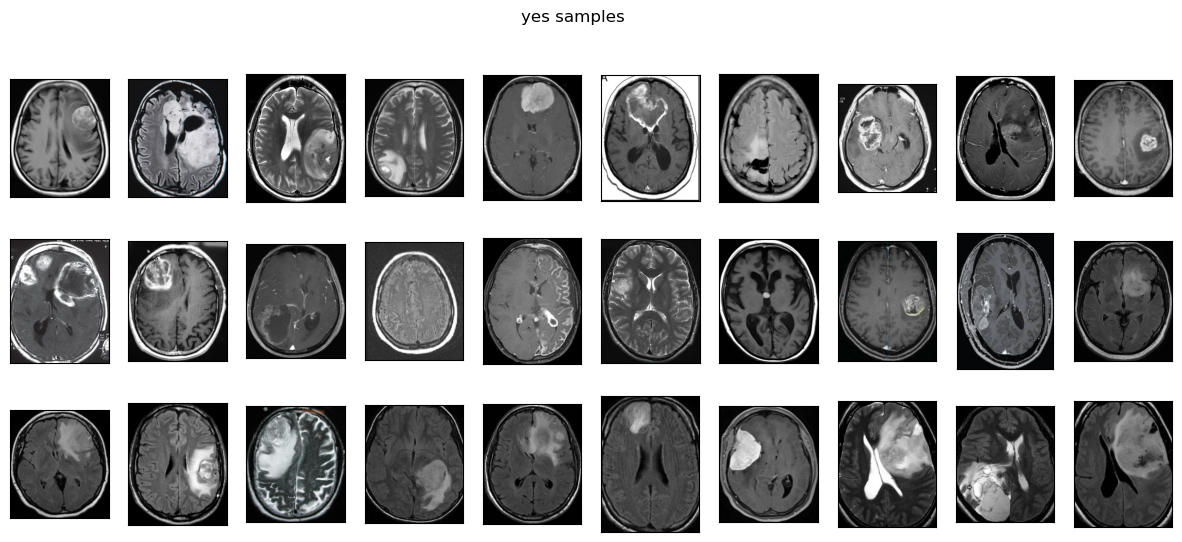

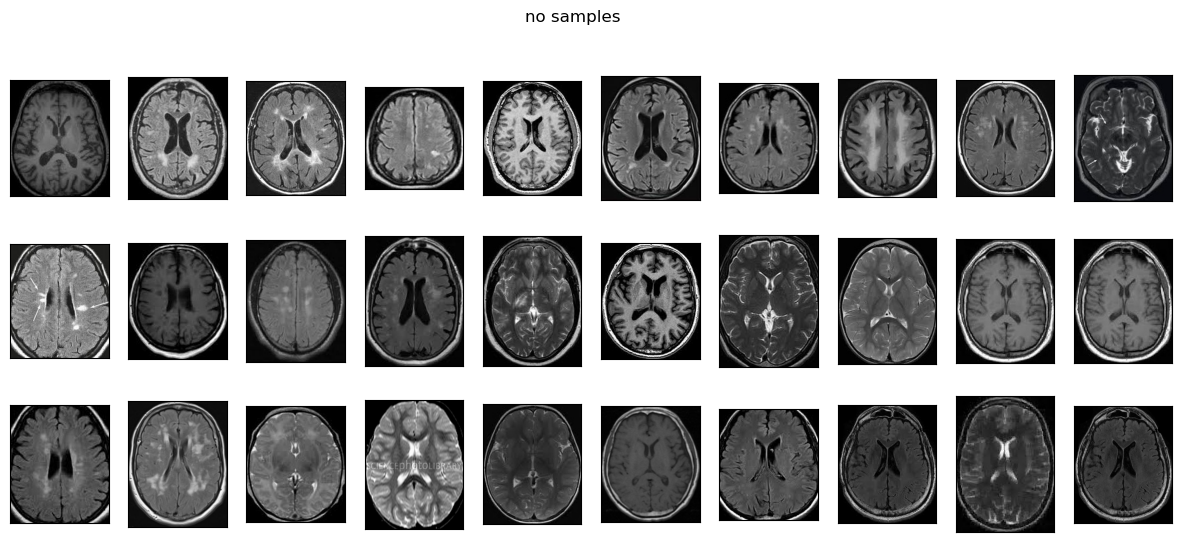

In [15]:
plot_samples(TRAIN_DIR_CROPED, n=30)

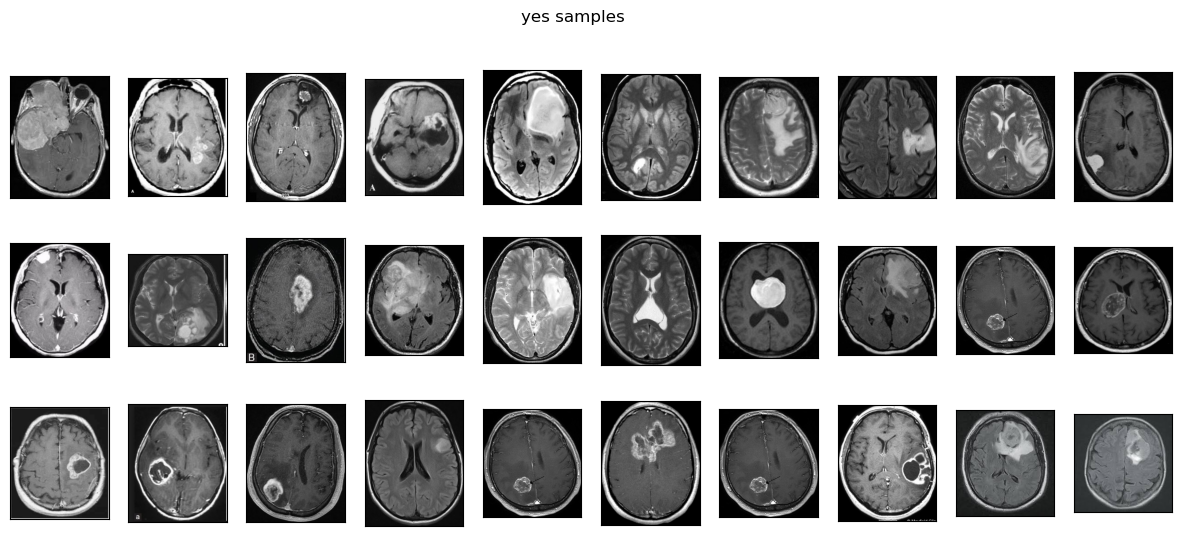

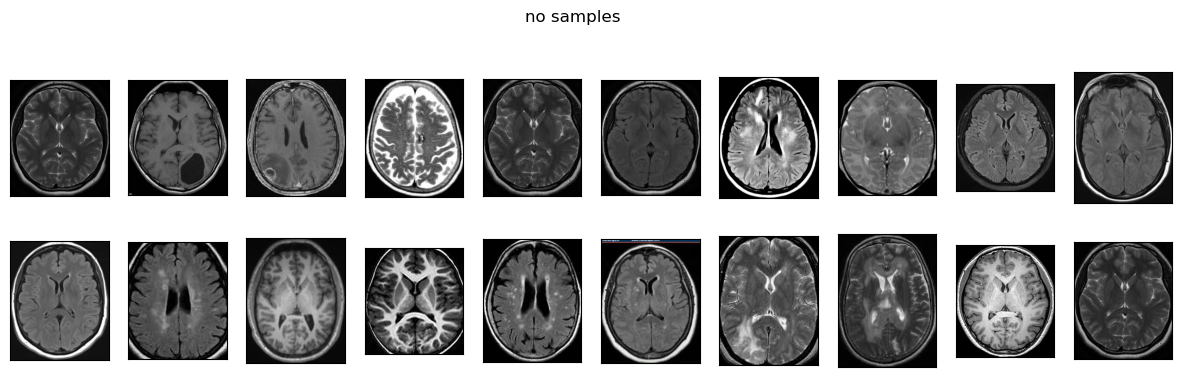

In [16]:
plot_samples(VAL_DIR_CROPED, n=30)

因为图片数量少，数据集使用ImageDataGenerator生成，这里使用了旋转，平移，缩放，剪切，翻转等操作

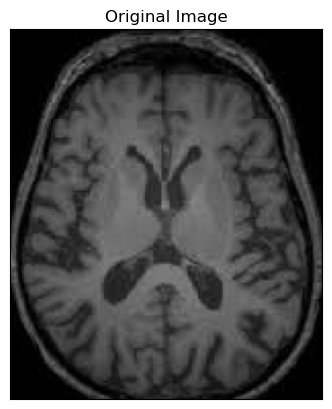

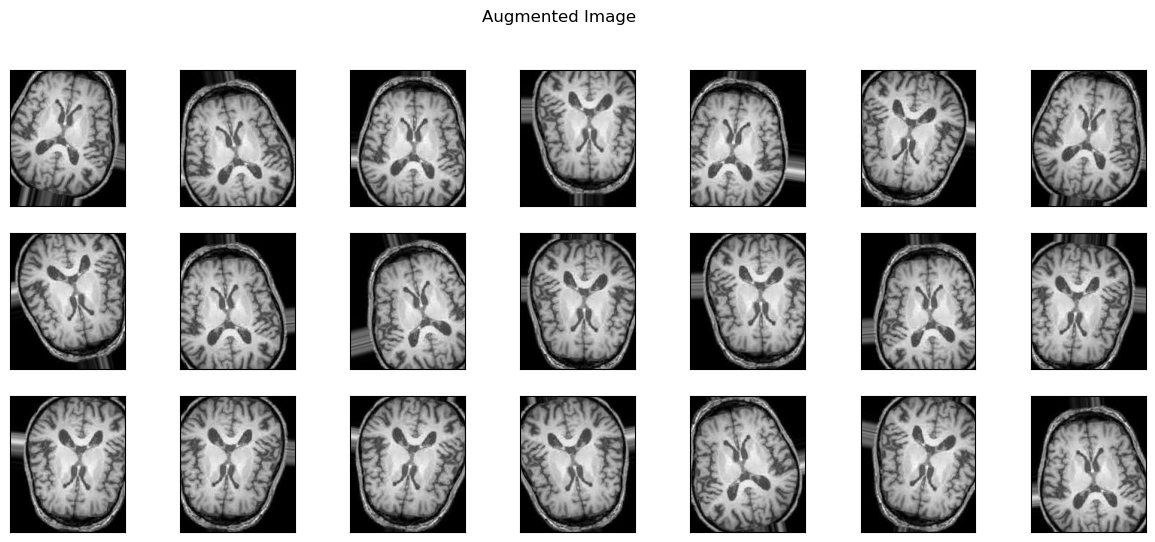

In [17]:
demo_idg = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.1, 1.5),
    rescale=1.0 / 255,
    shear_range=0.05,
)

if not os.path.exists("./dataset/preview"):
    os.mkdir("./dataset/preview")

sample_org = X_train_croped[0]
sample = sample_org.reshape((1,) + sample_org.shape)

i = 0
for batch in demo_idg.flow(
    sample,
    batch_size=1,
    save_to_dir="./dataset/preview",
    save_prefix="demo",
    save_format="jpg",
):
    i += 1
    if i > 20:
        break

plt.imshow(sample_org)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.show()


plt.figure(figsize=(15, 6))


for i, img in enumerate(os.listdir("./dataset/preview/")):
    if i >= 3 * 7:
        break
    img = cv2.imread(os.path.join("./dataset/preview/", img))

    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])


plt.suptitle("Augmented Image")
plt.show()

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    rescale=1.0 / 255,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_CROPED,
    color_mode="rgb",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="binary",
    # shuffle=True,
    seed=RANDOM_SEED,
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR_CROPED,
    color_mode="rgb",
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode="binary",
    seed=RANDOM_SEED,
)

Found 192 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [13]:
base_model = VGG16(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model = Sequential()

model.add(base_model)
model.add(layers.Flatten())
# model.add(layers.ReLU())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.layers[0].trainable = False

model.compile(
    loss="binary_crossentropy",
    # optimizer=RMSprop(learning_rate=1e-4),
    optimizer=Adam(learning_rate=1e-3, epsilon=1e-7),
    # optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 re_lu (ReLU)                (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
EPOCHS = 200

es = EarlyStopping(
    # monitor="val_accuracy",
    # mode="max",
    min_delta=1e-4,
    patience=40,
    restore_best_weights=True,
)

mcp_save = ModelCheckpoint(
    "mdl_best_wts.hdf5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
)

history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples / train_generator.batch_size,
    # steps_per_epoch=50,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples / validation_generator.batch_size,
    # validation_steps=25,
    validation_steps=len(validation_generator),
    callbacks=[mcp_save, es],
)

Epoch 1/200
6/6 [==============================] - 30s 2s/step - loss: 0.9149 - accuracy: 0.5938 - val_loss: 0.9134 - val_accuracy: 0.3922
Epoch 2/200
6/6 [==============================] - 3s 577ms/step - loss: 0.8919 - accuracy: 0.5260 - val_loss: 0.8890 - val_accuracy: 0.6078
Epoch 3/200
6/6 [==============================] - 3s 570ms/step - loss: 0.7135 - accuracy: 0.6979 - val_loss: 0.6531 - val_accuracy: 0.5686
Epoch 4/200
6/6 [==============================] - 3s 563ms/step - loss: 0.6701 - accuracy: 0.6302 - val_loss: 0.5631 - val_accuracy: 0.6863
Epoch 5/200
6/6 [==============================] - 3s 580ms/step - loss: 0.5805 - accuracy: 0.7083 - val_loss: 0.4744 - val_accuracy: 0.7451
Epoch 6/200
6/6 [==============================] - 4s 582ms/step - loss: 0.5832 - accuracy: 0.6875 - val_loss: 0.4739 - val_accuracy: 0.7647
Epoch 7/200
6/6 [==============================] - 4s 586ms/step - loss: 0.5098 - accuracy: 0.7292 - val_loss: 0.4244 - val_accuracy: 0.7843
Epoch 8/200
6/6

<Axes: >

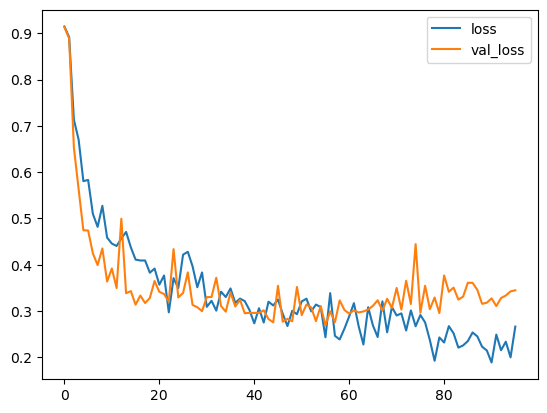

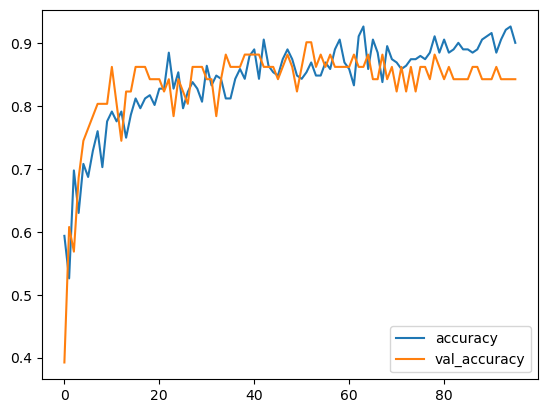

In [16]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["accuracy", "val_accuracy"]].plot()

加载最优模型

In [19]:
model.load_weights("mdl_best_wts.hdf5")

处理验证集图片

In [28]:
X_test_resized = []

for img in X_test_croped:
    img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    X_test_resized.append(img_resized)

In [32]:
# predict
pred = model.predict(np.array(X_test_resized) / 255.0)
predictions = pred.round()
# target
y_test_array = np.array(y_test)
y_test_array[y_test_array == "yes"] = 1
y_test_array[y_test_array == "no"] = 0

y_test_int = y_test_array.astype(int)

1/1 [==============================] - 0s 37ms/step


In [33]:
print(classification_report(y_test_int, predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [24]:
accuracy = accuracy_score(y_test_int, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.90


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

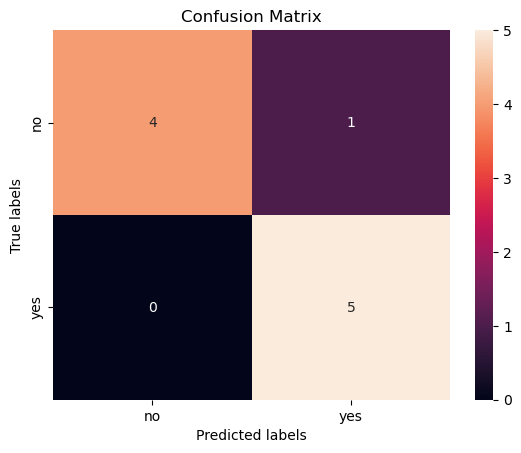

In [25]:
ax = plt.subplot()

confusion_mtx = confusion_matrix(y_test_int, predictions)
sns.heatmap(confusion_mtx, annot=True, fmt="g")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["no", "yes"])
ax.yaxis.set_ticklabels(["no", "yes"])